In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## DATASET CLASS

In [8]:
class DEAPDataset(Dataset):
    def __init__(self, feature_path, label_path, exclude_subject=None, only_subject=None, normalize=True, train=False, noise_std=0.05):
        self.features = np.load(feature_path)  # shape: (32, 40, 40, 5, 63)
        self.labels = np.load(label_path)      # shape: (32, 40, 63)
        self.train = train
        self.noise_std = noise_std

        if normalize:
            all_features = []
            for subj in range(32):
                if exclude_subject is not None and subj == exclude_subject:
                    continue
                if only_subject is not None and subj != only_subject:
                    continue

                subj_features = self.features[subj].transpose(0, 1, 3, 2).reshape(-1, 40, 5)
                all_features.append(subj_features)

            if all_features:
                all_features = np.concatenate(all_features, axis=0)
                self.mean = np.mean(all_features, axis=0)
                self.std = np.std(all_features, axis=0) + 1e-8
            else:
                self.mean = 0
                self.std = 1
        else:
            self.mean = 0
            self.std = 1

        self.samples = []
        for subj in range(32):
            if exclude_subject is not None and subj == exclude_subject:
                continue
            if only_subject is not None and subj != only_subject:
                continue

            for trial in range(40):
                for win in range(63):
                    x = self.features[subj, trial, :, :, win]
                    y = self.labels[subj, trial, win]
                    self.samples.append((x, y, subj))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y, subj = self.samples[idx]
        x = (x - self.mean) / self.std

        if self.train:
            x = torch.tensor(x, dtype=torch.float32)

            # ✅ Add Gaussian jitter
            x += torch.randn_like(x) * 0.01

            # ✅ Channel-wise dropout (spatial masking)
            if np.random.rand() < 0.3:
                mask = torch.rand(x.shape[1]) > 0.2
                x[:, ~mask] = 0
        else:
            x = torch.tensor(x, dtype=torch.float32)

        return x, int(y)

    def get_subject_data(self, subject):
        return [(torch.tensor((x - self.mean) / self.std, dtype=torch.float32), int(y))
                for x, y, subj in self.samples if subj == subject]


## MODEL ARCHITECTURE

In [9]:
class CommonFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=5, hidden_size=128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, 64)  # Bidirectional output
        self.bn = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.view(x.size(0), 40, 5)  # Reshape to (batch, time, features)
        _, h = self.gru(x)  # h: (2, batch, 128)
        h = torch.cat([h[0], h[1]], dim=1)  # (batch, 256)
        out = self.fc(h)  # (batch, 64)
        out = self.bn(out)
        out = F.normalize(out, p=2 ,dim=1)
        return out

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch, channels)
        scale = self.fc1(x)
        scale = self.relu(scale)
        scale = self.fc2(scale)
        scale = self.sigmoid(scale)
        return x * scale

class SubjectSpecificMapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(64, 32)
        self.bn = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.1)
        self.act = nn.LeakyReLU()
        self.se = SEBlock(32)

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.se(x)
        x = F.normalize(x, p=2 ,dim=1)
        return x


class SubjectSpecificClassifier(nn.Module):
    def __init__(self , temperature=1.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(32)
        self.fc = nn.Linear(32, 4)
        self.temperature = temperature

    def forward(self, x):
        x = self.bn(x)
        logits = self.fc(x)
        return logits / self.temperature


## LOSS FUNCTION

In [10]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        features = F.normalize(features, dim=1)
        batch_size = features.shape[0]

        # Handle case where batch size is 1
        if batch_size <= 1:
            return torch.tensor(0.0, device=features.device, requires_grad=True)

        sim_matrix = torch.matmul(features, features.T) / self.temperature
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(features.device)
        logits_mask = torch.ones_like(mask) - torch.eye(batch_size).to(features.device)
        mask = mask * logits_mask

        # Handle case where there are no positive pairs
        if mask.sum() == 0:
            return torch.tensor(0.0, device=features.device, requires_grad=True)

        exp_sim = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-9)
        loss = - (mask * log_prob).sum() / (mask.sum() + 1e-9)
        return loss

class MMDLoss(nn.Module):
    def __init__(self, kernel_mul=2.0, num_kernels=5):
        super().__init__()
        self.kernel_mul = kernel_mul
        self.num_kernels = num_kernels

    def gaussian_kernel(self, source, target):
        total = torch.cat([source, target], dim=0)

        # Handle small batch sizes
        if total.shape[0] <= 1:
            return torch.tensor(0.0, device=source.device, requires_grad=True)

        total0 = total.unsqueeze(0)
        total1 = total.unsqueeze(1)
        L2_distance = ((total0 - total1) ** 2).sum(2)

        # Prevent division by zero
        bandwidth = torch.mean(L2_distance.detach()) + 1e-8
        bandwidth_list = [bandwidth * (self.kernel_mul ** i) for i in range(self.num_kernels)]
        kernels = [torch.exp(-L2_distance / bw) for bw in bandwidth_list]
        return sum(kernels) / len(kernels)

    def forward(self, source, target):
        source = source.view(source.size(0), -1)
        target = target.view(target.size(0), -1)

        # Handle empty batches
        if source.shape[0] == 0 or target.shape[0] == 0:
            return torch.tensor(0.0, device=source.device, requires_grad=True)

        kernels = self.gaussian_kernel(source, target)
        batch_size = source.size(0)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        return torch.mean(XX + YY - XY - YX)

class ContrastiveLossLcon2(nn.Module):
    def __init__(self, feature_dim=32, num_classes=4, tau=0.1, gamma=0.5, queue_size=1024):
        super().__init__()
        self.tau = tau
        self.gamma = gamma
        self.prototypes = nn.Parameter(torch.randn(num_classes, feature_dim))
        self.register_buffer("queue", torch.randn(queue_size, feature_dim))
        self.queue = F.normalize(self.queue, dim=-1)

    def forward(self, z_t, pseudo_labels):
        # Handle empty batches
        if z_t.shape[0] == 0:
            return torch.tensor(0.0, device=z_t.device, requires_grad=True)

        z_t = F.normalize(z_t, dim=-1)
        device = z_t.device
        pseudo_labels = pseudo_labels.to(device)

        pos_proto = self.prototypes.to(device)[pseudo_labels]

        # Compute positive and negative logits
        pos_logits = torch.sum(z_t * pos_proto, dim=-1) / self.tau

        # Handle case where queue is empty
        if self.queue.shape[0] == 0:
            return self.gamma * F.cross_entropy(pos_logits.unsqueeze(1), torch.zeros(z_t.size(0), dtype=torch.long, device=device))

        neg_logits = torch.matmul(z_t, self.queue.to(device).T) / self.tau
        logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        labels = torch.zeros(z_t.size(0), dtype=torch.long).to(device)

        loss = F.cross_entropy(logits, labels)
        self._dequeue_and_enqueue(z_t)
        return self.gamma * loss

    @torch.no_grad()
    def _dequeue_and_enqueue(self, embeddings):
        embeddings = embeddings.detach().to(self.queue.device)
        batch_size = embeddings.size(0)
        queue_size = self.queue.size(0)

        if batch_size >= queue_size:
            self.queue = embeddings[-queue_size:]
        else:
            self.queue = torch.cat([self.queue[batch_size:], embeddings], dim=0)

class GeneralizedCrossEntropy(nn.Module):
    def __init__(self, q=0.7, weight=None):
        super().__init__()
        self.q = q
        self.weight = weight  # class weights (tensor)

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)

        # Handle empty batches
        if targets.shape[0] == 0:
            return torch.tensor(0.0, device=logits.device, requires_grad=True)

        targets_onehot = F.one_hot(targets, num_classes=probs.shape[1]).float()
        probs = torch.sum(probs * targets_onehot, dim=1)

        if self.weight is not None:
            weights = self.weight[targets]
            loss = (1 - probs ** self.q) / self.q
            return (weights * loss).mean()
        else:
            return ((1 - probs ** self.q) / self.q).mean()

class FocalLossWithSmoothing(nn.Module):
    def __init__(self, gamma=2.0, smoothing=0.1, weight=None, reduction='mean'):
        """
        Focal Loss with optional label smoothing.
        Args:
            gamma (float): focusing parameter for modulating factor (1 - p_t)
            smoothing (float): label smoothing factor
            weight (torch.Tensor): class weights
            reduction (str): 'mean' or 'sum'
        """
        super(FocalLossWithSmoothing, self).__init__()
        self.gamma = gamma
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    def forward(self, logits, targets):
        num_classes = logits.size(1)

        # Convert to one-hot with label smoothing
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, targets.data.unsqueeze(1), 1.0 - self.smoothing)

        probs = F.softmax(logits, dim=1)
        probs = torch.clamp(probs, 1e-6, 1.0)  # avoid log(0)

        # Focal loss component
        log_probs = torch.log(probs)
        focal_weight = (1 - probs) ** self.gamma

        loss = -true_dist * focal_weight * log_probs

        # Apply class weights
        if self.weight is not None:
            weight = self.weight.unsqueeze(0)  # (1, num_classes)
            loss = loss * weight

        # loss = loss.sum(dim=1)  # sum over classes

        if self.reduction == 'mean':
            return loss.mean()
        # elif self.reduction == 'sum':
        #     return loss.sum()
        else:
            return loss.sum()  # no reduction

class PrototypeContrastiveLoss(nn.Module):
    def __init__(self, feature_dim=32, num_classes=4, tau=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.tau = tau
        # Initialize class prototypes
        self.register_buffer('prototypes', torch.zeros(num_classes, feature_dim))
        self.register_buffer('prototype_counts', torch.zeros(num_classes))
        
    def forward(self, features, labels):
        # Update prototypes with moving average
        for c in range(self.num_classes):
            class_mask = (labels == c)
            if class_mask.sum() > 0:
                class_features = features[class_mask]
                class_mean = class_features.mean(0)
                
                # Update prototype with momentum
                momentum = 0.9
                self.prototypes[c] = momentum * self.prototypes[c] + (1 - momentum) * class_mean
                self.prototype_counts[c] += 1
        
        # Normalize prototypes
        valid_prototypes = self.prototype_counts > 0
        if valid_prototypes.sum() > 0:
            self.prototypes[valid_prototypes] = F.normalize(self.prototypes[valid_prototypes], dim=1)
        
        # Compute distances to prototypes
        features_norm = F.normalize(features, dim=1)
        logits = features_norm @ self.prototypes.t() / self.tau
        
        # Compute contrastive loss
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        loss = -torch.sum(labels_onehot * F.log_softmax(logits, dim=1)) / labels.size(0)
        
        return loss

class DynamicWeightedLoss(nn.Module):
    """Loss function with dynamically adjusted class weights based on performance"""
    def __init__(self, num_classes=4, initial_weights=None, momentum=0.9):
        super().__init__()
        self.num_classes = num_classes
        self.focal_loss = FocalLossWithSmoothing(gamma=2.0, smoothing=0.1)
        self.register_buffer('weights', torch.ones(num_classes) if initial_weights is None else initial_weights)
        self.register_buffer('class_accuracies', torch.ones(num_classes))
        self.momentum = momentum
        
    def update_weights(self, logits, targets):
        """Update weights based on per-class accuracy"""
        with torch.no_grad():
            preds = logits.argmax(dim=1)
            for c in range(self.num_classes):
                # Find samples of this class
                class_mask = (targets == c)
                if class_mask.sum() > 0:
                    # Calculate accuracy for this class
                    correct = (preds[class_mask] == targets[class_mask]).float().mean()
                    # Update running average of class accuracy
                    self.class_accuracies[c] = self.momentum * self.class_accuracies[c] + (1 - self.momentum) * correct
            
            # Inverse of accuracy as weight (lower accuracy = higher weight)
            new_weights = 1.0 / (self.class_accuracies + 1e-5)
            # Normalize weights
            new_weights = new_weights / new_weights.sum() * self.num_classes
            self.weights = new_weights
            
    def forward(self, logits, targets):
        # Update weights based on current batch performance
        self.update_weights(logits, targets)
        # Apply weights to focal loss
        self.focal_loss.weight = self.weights
        return self.focal_loss(logits, targets)


## TRAINING LOOP

In [11]:
def get_target_batch(dataset, exclude, batch_size=64):
    """Get a batch of data from target subjects"""
    for subj in range(32):
        if subj != exclude:
            data = dataset.get_subject_data(subj)
            if len(data) >= batch_size:
                indices = torch.randperm(len(data))[:batch_size]
                x, y = zip(*[data[i] for i in indices])
                return torch.stack(x), torch.tensor(y)

    # Fallback: Return a small batch if no subject has enough data
    all_data = []
    for subj in range(32):
        if subj != exclude:
            all_data.extend(dataset.get_subject_data(subj))

    if len(all_data) == 0:
        # Empty tensor with correct shape as a fallback
        empty_sample = next(iter(dataset))
        return torch.zeros((0, *empty_sample[0].shape), dtype=torch.float32), torch.zeros(0, dtype=torch.long)

    indices = torch.randperm(len(all_data))[:min(batch_size, len(all_data))]
    x, y = zip(*[all_data[i] for i in indices])
    return torch.stack(x), torch.tensor(y)

def plot_confusion_matrix(y_true, y_pred, subject_idx):
    """Create and save confusion matrix plot"""
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Subject {subject_idx+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'plots/new_confmat_subject{subject_idx+1}.png')
    plt.close()

Using device: cuda

🚀 Training on all subjects together with contrastive + domain adaptation
Classs distribution: [16380 18648 16758 28854]
Class weights: tensor([1.2308, 1.0811, 1.2030, 0.6987], device='cuda:0')


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Per-class accuracy:
Class 0: 0.2318 (13104 / 13104)
Class 1: 0.3159 (14918 / 14918)
Class 2: 0.2322 (13407 / 13407)
Class 3: 0.2144 (23083 / 23083)
Current class weights: [1.2307693  1.081081   1.2030075  0.69868994]
Epoch [1/400] - Loss: 5.2515 - Train Acc: 0.2451

Per-class accuracy:
Class 0: 0.2549 (13104 / 13104)
Class 1: 0.3273 (14918 / 14918)
Class 2: 0.2116 (13407 / 13407)
Class 3: 0.2021 (23083 / 23083)
Current class weights: [1.2307693  1.081081   1.2030075  0.69868994]
Epoch [2/400] - Loss: 4.1429 - Train Acc: 0.2437

Per-class accuracy:
Class 0: 0.2201 (13104 / 13104)
Class 1: 0.3124 (14918 / 14918)
Class 2: 0.2513 (13407 / 13407)
Class 3: 0.2151 (23083 / 23083)
Current class weights: [1.2307693  1.081081   1.2030075  0.69868994]
Epoch [3/400] - Loss: 4.1426 - Train Acc: 0.2461

Per-class accuracy:
Class 0: 0.2507 (13104 / 13104)
Class 1: 0.3197 (14918 / 14918)
Class 2: 0.2394 (13407 / 13407)
Class 3: 0.2151 (23083 / 23083)
Current class weights: [1.2307693  1.081081   1.20

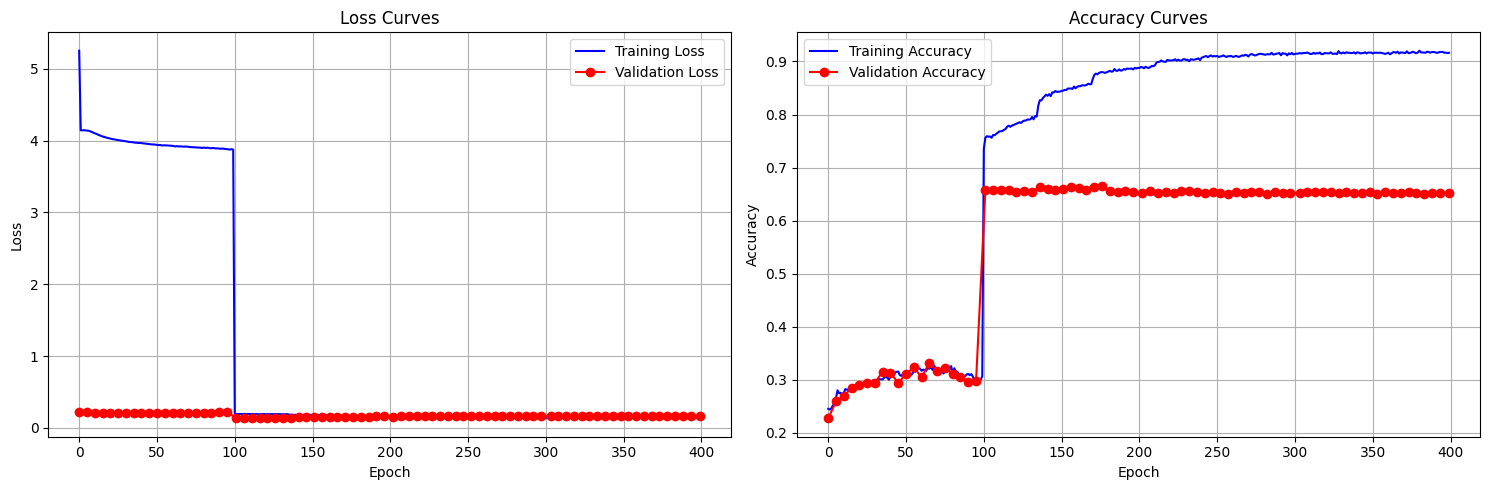

In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def augment_eeg(x, p=0.5):
    # More sophisticated augmentation techniques
    if torch.rand(1, device=x.device) < p:
        # Gaussian noise with adaptive magnitude
        noise_level = 0.01 + 0.02 * torch.rand(1, device=x.device)
        noise = torch.randn_like(x) * noise_level
        x = x + noise
        
    if torch.rand(1, device=x.device) < p:
        # Random scaling with more variation
        scale = 0.9 + 0.2 * torch.rand(1, device=x.device)
        x = x * scale
        
    if torch.rand(1, device=x.device) < p:
        # Channel dropout (randomly zero out some channels)
        mask = torch.bernoulli(torch.ones_like(x) * 0.9).to(x.device)
        x = x * mask
        
    if torch.rand(1, device=x.device) < p:
        # Time masking (simulate artifacts)
        batch_size = x.size(0)
        feature_dim = x.size(1)
        mask_length = int(feature_dim * 0.1)
        start = torch.randint(0, feature_dim - mask_length, (batch_size,), device=x.device)
        
        mask = torch.ones_like(x)
        for i in range(batch_size):
            mask[i, start[i]:start[i]+mask_length] = 0
        x = x * mask
        
    return x
# ------------------ Training Function ------------------
def train_all_subjects(feature_path, label_path, num_epochs=100, batch_size=64, warmup_epochs=100):
    print("\n🚀 Training on all subjects together with contrastive + domain adaptation")
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    dataset = DEAPDataset(feature_path, label_path, normalize=True, train=True)
    indices = list(range(len(dataset)))
    targets = [label for _, label in dataset]
    train_idx, test_idx, _, _ = train_test_split(
        indices, targets, test_size=0.2, stratify=targets, random_state=42
    )

    train_set = Subset(dataset, train_idx)
    test_set = Subset(DEAPDataset(feature_path,label_path,normalize=True,train=False), test_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Init models
    cfe = CommonFeatureExtractor().to(device)
    sfe = SubjectSpecificMapper().to(device)
    ssc = SubjectSpecificClassifier(temperature = 2.0).to(device)

    # Init losses

    labels_np = np.array([label for _, label in dataset])
    # class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_np), y=labels_np)
    # class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    class_counts = np.bincount(labels_np)
    print(f"Classs distribution: {class_counts}")
    
    initial_weights = compute_class_weight('balanced', classes=np.unique(labels_np), y=labels_np)
    class_weights = torch.tensor(initial_weights, dtype=torch.float32).to(device)
    print(f"Class weights: {class_weights}")
    
    

    loss_con1 = SupervisedContrastiveLoss(temperature=0.07).to(device)
    loss_mmd = MMDLoss().to(device)
    loss_con2 = ContrastiveLossLcon2().to(device)
    # loss_cls = GeneralizedCrossEntropy(q=0.5, weight=class_weights).to(device)
    # loss_cls = FocalLossWithSmoothing(gamma=2.0, smoothing=0.1, weight=class_weights).to(device)
    loss_cls = DynamicWeightedLoss(num_classes=4, initial_weights=class_weights).to(device)
    loss_proto = PrototypeContrastiveLoss(feature_dim=32 , num_classes=4 , tau=0.1).to(device)


    optimizer = torch.optim.AdamW(
        list(cfe.parameters()) + list(sfe.parameters()) + list(ssc.parameters()),
        lr=2e-3, weight_decay=1e-3
    )
    

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True , min_lr=1e-6 )

    pateince = 10
    early_stop_counter = 0
    best_acc = 0
    for epoch in range(num_epochs):
        cfe.train()
        sfe.train()
        ssc.train()

        epoch_loss, correct, total = 0, 0, 0
        mmd_weight = max(0.1*(1 - epoch / num_epochs), 0.01)  # Decrease MMD weight over epochs
        
        class_correct = torch.zeros(4).to(device)
        class_total = torch.zeros(4).to(device)

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            xb_aug = augment_eeg(xb.clone())
            
            optimizer.zero_grad()

            z_common_org = cfe(xb)
            z_common_aug = cfe(xb_aug)
            
            z_subject = sfe(z_common_org)
            logits = ssc(z_subject)

            if epoch < warmup_epochs:
                loss = loss_con1(z_common_org, yb)
            else:
                with torch.no_grad():
                    
                    pseudo_logits = ssc(sfe(cfe(xb)))
                    pseudo_probs = F.softmax(pseudo_logits, dim=1)
                    pseudo_entropy = -torch.sum(pseudo_probs * torch.log(pseudo_probs + 1e-9), dim=1)
                    
                    probs = F.softmax(logits, dim=1)
                    confidence = torch.max(probs, dim=1)[0]
                    penalty = confidence.mean()
                    # pseudo_labels = pseudo_logits.argmax(dim=1)
                
                    # Adaptive threshold: starts strict, loosens
                entropy_threshold = max(0.9, 1.5 - epoch / num_epochs)
                
                confident_mask = pseudo_entropy < entropy_threshold
                
                z_subject_filtered = z_subject[confident_mask].detach()
                pseudo_labels_filtered = pseudo_logits.argmax(dim=1)[confident_mask].detach()
                
                if z_subject_filtered.size(0) > 0:
                    # contrastive_loss = loss_con2(z_subject_filtered , pseudo_labels_filtered)
                    contrastive_loss = loss_proto(z_subject_filtered , pseudo_labels_filtered)
                else:
                    contrastive_loss = torch.tensor(0.0 , device=device)
                    
                alpha = min(epoch / num_epochs *2 , 1.0)
                                    
                beta = 0.1
                loss = 1.0 * loss_cls(logits, yb) + \
                       alpha * (0.5 * contrastive_loss) + \
                       alpha * (mmd_weight * loss_mmd(z_common_org, z_common_aug)) + \
                       beta * penalty

            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(cfe.parameters()) + list(sfe.parameters()) + list(ssc.parameters()), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()

            preds = logits.argmax(1)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)
            
            for c in range(4):
                class_mask = (yb == c)
                if class_mask.sum() > 0:
                    class_correct[c] += (preds[class_mask] == yb[class_mask]).sum().item()
                    class_total[c] += class_mask.sum().item()
        
        print("\nPer-class accuracy:")
        for c in range(4):
            if class_total[c] > 0:
                class_acc = class_correct[c] / class_total[c]
                print(f"Class {c}: {class_acc:.4f} ({int(class_total[c])} / {int(class_total[c])})")
            else:
                print(f"Class {c}: No samples")
        
        print(f"Current class weights: {loss_cls.weights.cpu().numpy()}")
            
        train_loss = epoch_loss/ len(train_loader)
        train_acc = correct / total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")

        # Validation
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            cfe.eval(); sfe.eval(); ssc.eval()
            val_loss = 0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for xb, yb in test_loader:
                    yb = yb.to(device)
                    xb = xb.to(device)
                    z = sfe(cfe(xb))
                    logits = ssc(z)
                    
                    val_loss += loss_cls(logits, yb).item()
                    
                    all_preds.extend(logits.argmax(1).cpu().numpy())
                    all_labels.extend(yb.cpu().numpy())
            
            val_loss = val_loss/len(test_loader)
            val_acc = accuracy_score(all_labels, all_preds)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            print(f"📊 Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
            scheduler.step(val_acc)
            
            if val_acc > best_acc:
                best_acc = val_acc
                early_stop_counter = 0
                torch.save({
                    'cfe': cfe.state_dict(),
                    'sfe': sfe.state_dict(),
                    'ssc': ssc.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch + 1
                }, f"checkpoints/new_best_model.pt")
                print(f"🏆 New best accuracy: {best_acc:.4f}")
            else:
                early_stop_counter = 0
                print(f"Early stopping counter: {early_stop_counter}")
                if early_stop_counter >= pateince:
                    print(f"Early stopping triggered after {pateince} epochs without improvement.")
                    break

    print("\n✅ Training complete.")
    print(f"Best Val Accuracy: {best_acc:.4f}")

    # Final Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - All Subjects')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('plots/new_confmat_all_subjects.png')
    plt.close()
    
    plot_training_curves(train_losses, train_accs, val_losses, val_accs, save_path="plots/new_final_training_curves.png")

    return best_acc, all_labels, all_preds , train_losses , train_accs , val_losses , val_accs

def plot_training_curves(train_losses, train_accs, val_losses, val_accs, save_path=None):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    if val_losses:
        # Plot validation points where we have them
        val_indices = np.linspace(0, len(train_losses)-1, len(val_losses)).astype(int)
        ax1.plot(val_indices, val_losses, label='Validation Loss', color='red', marker='o')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    if val_accs:
        # Plot validation points where we have them
        val_indices = np.linspace(0, len(train_accs)-1, len(val_accs)).astype(int)
        ax2.plot(val_indices, val_accs, label='Validation Accuracy', color='red', marker='o')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()
# ------------------ Main ------------------
if __name__ == "__main__":
    feature_path = r"E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\de_features.npy"
    label_path = r"E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\de_labels.npy"
    train_all_subjects(feature_path, label_path, num_epochs=400, batch_size=64)

## TESTING

In [13]:
def load_trained_model(checkpoint_path="E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\checkpoints/new_best_model.pt"):
    cfe = CommonFeatureExtractor().to(device)
    sfe = SubjectSpecificMapper().to(device)
    ssc = SubjectSpecificClassifier().to(device)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    cfe.load_state_dict(checkpoint['cfe'])
    sfe.load_state_dict(checkpoint['sfe'])
    ssc.load_state_dict(checkpoint['ssc'])

    cfe.eval()
    sfe.eval()
    ssc.eval()
    return cfe, sfe, ssc


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamza\AppData\Local\Temp\ipykernel_18420\3770540988.py:1: SyntaxWarning: invalid escape sequence '\F'
  def load_trained_model(checkpoint_path="E:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\FYP_2\Hamza\checkpoints/new_best_model.pt"):


In [14]:
def test_model(feature_path, label_path, checkpoint_path="E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/FYP_2/Hamza/checkpoints/new_best_model.pt", batch_size=64):
    print("🔍 Testing saved model...")

    # Load the model
    cfe, sfe, ssc = load_trained_model(checkpoint_path)

    # Prepare dataset
    dataset = DEAPDataset(feature_path, label_path, normalize=True)
    indices = list(range(len(dataset)))
    labels = [label for _, label in dataset]
    _, test_idx, _, _ = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=42)
    test_set = Subset(dataset, test_idx)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            z = sfe(cfe(xb))
            logits = ssc(z)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("plots/new_test_confmat.png")
    plt.close()

    return acc, all_labels, all_preds


In [15]:
if __name__ == "__main__":
    feature_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_features.npy"
    label_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_labels.npy"
    test_model(feature_path, label_path)


🔍 Testing saved model...
✅ Test Accuracy: 0.6651


In [16]:
from sklearn.manifold import TSNE

def plot_tsne_features(cfe, sfe, ssc, feature_path, label_path, layer="sfe", num_samples=2000):
    dataset = DEAPDataset(feature_path, label_path, normalize=True)
    indices = list(range(len(dataset)))
    labels = [label for _, label in dataset]
    _, test_idx, _, _ = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=42)
    test_set = Subset(dataset, test_idx)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

    all_feats, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            z_cfe = cfe(xb)                     # 64-d
            z_sfe = sfe(z_cfe)                  # 32-d
            feats = z_sfe if layer == "sfe" else z_cfe
            all_feats.append(feats.cpu())
            all_labels.append(yb)

            if len(torch.cat(all_feats)) >= num_samples:
                break

    all_feats = torch.cat(all_feats)[:num_samples]
    all_labels = torch.cat(all_labels)[:num_samples]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
    tsne_feats = tsne.fit_transform(all_feats)

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_feats[:, 0], tsne_feats[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(f"t-SNE of {'SFE' if layer == 'sfe' else 'CFE'} features")
    plt.savefig(f"plots/new_tsne_{layer}_features.png")
    plt.show()


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


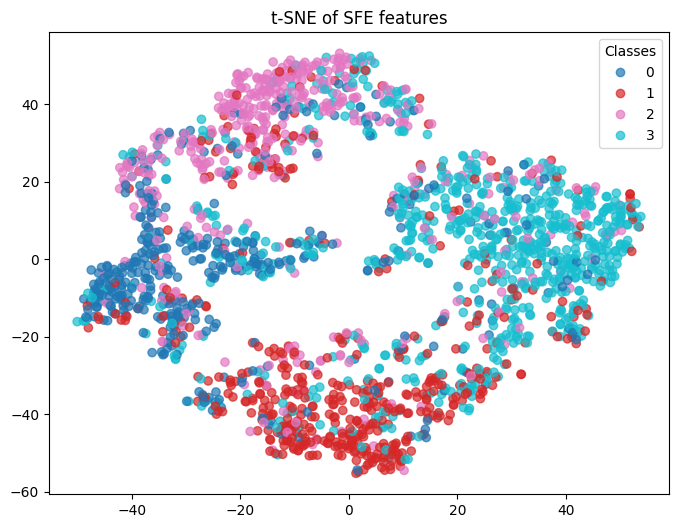

In [17]:
if __name__ == "__main__":
    feature_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_features.npy"
    label_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/de_labels.npy"

    # Load the model
    cfe, sfe, ssc = load_trained_model("E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/FYP_2/Hamza/checkpoints/new_best_model.pt")

    # Plot t-SNE from either 'cfe' or 'sfe'
    plot_tsne_features(cfe, sfe, ssc, feature_path, label_path, layer="sfe")


e:\FYP\Finalise Fyp\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


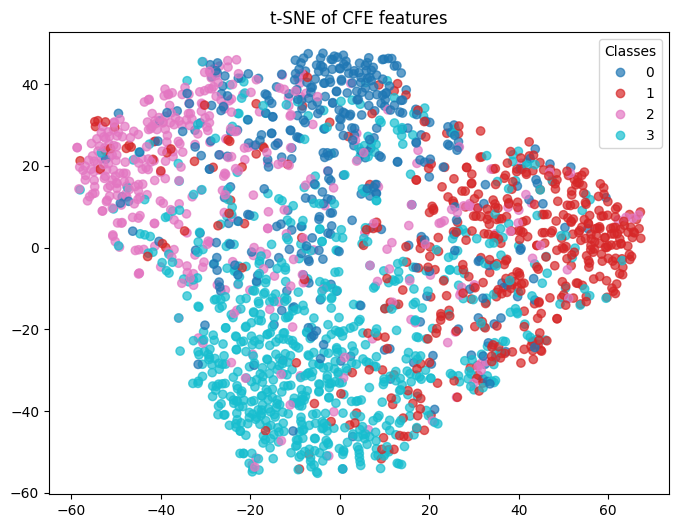

In [18]:
plot_tsne_features(cfe, sfe, ssc, feature_path, label_path, layer="cfe")
